# Deep Fluids Test Data Conversion

After generating data using tester.py with the option to save data, this script will import the predicted field, denormalize it, and output the data to a numpy format that can be used by the PerformanceAnalysis scripts.

## Inputs
* the dataset folder. Must contain an args.txt file and idx_test.txt specifying the indices of the test samples. Assumed to be in deep-fluids/data/cmag_dataset
* the test folder. Must contain the predictions of each test example. assumed to be in deep-fluids/test/cmag_dataset

## Outputs
This will save the prediction outputs in Models/CNN and Models/CNN-DF respectively. It will also generate figures in the Figures folder

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import os.path
import math
import glob
import re
from functions.deep_fluids_utils import get_ranges, denorm, evaluate_generic_metrics, create_df, extract_stats
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
%matplotlib inline

In [5]:
# change this with the path to deep-fluids
DF_PATH = '/home/samuelch/src/deep-fluids/'

In [3]:
x_range, y_range = get_ranges(os.path.join(DF_PATH, 'data/cmag_dataset/args.txt'))

In [4]:
test_idx_fn = os.path.join(DF_PATH, 'data/cmag_dataset/idx_test.txt')
data_dir = os.path.join(DF_PATH, 'data/cmag_dataset/v/') 
test_dir = os.path.join(DF_PATH, 'test/cmag_dataset/v')

In [5]:
test_df = create_df(data_dir, test_dir, test_idx_fn, x_range, y_range)

In [6]:
grouped_metrics = lambda x: evaluate_generic_metrics(x[['Ox', 'Oy', 'Oz']].values, x[['Px', 'Py', 'Pz']].values)
test_by_current = test_df.groupby('currents_level').apply(grouped_metrics)

In [7]:
test_by_current.to_pickle('../Models/CNN/df_results_by_current_level')

In [8]:
np.save('../Models/CNN/observations.npy', test_df[['Ox','Oy', 'Oz']].values)
np.save('../Models/CNN/predictions.npy', test_df[['Px','Py', 'Pz']].values)

In [9]:
test_by_current = pd.read_pickle('../Models/CNN/df_results_by_current_level')

Text(0.5,0,'current level (A)')

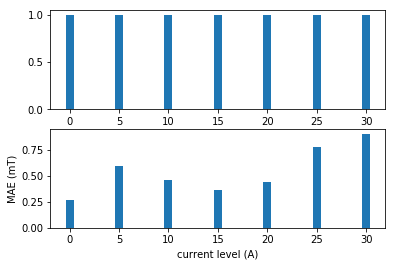

In [10]:
current_levels = list(test_by_current.keys())
plt.subplot(2,1,1)
plt.bar(current_levels, [test_by_current[l]['R2_norm'] for l in current_levels])
plt.subplot(2,1,2)
plt.bar(current_levels, [test_by_current[l]['MAE_mT'] for l in current_levels])
plt.ylabel('MAE (mT)')
plt.xlabel('current level (A)')

## Now Getting data for Div-free

In [11]:
test_idx_fn = os.path.join(DF_PATH, 'data/cmag_dataset/idx_test.txt') 
data_dir = os.path.join(DF_PATH, 'data/cmag_dataset/v/')
test_dir = os.path.join(DF_PATH, 'test/cmag_dataset_divfree/v')

In [13]:
test_df_divfree = create_df(data_dir, test_dir, test_idx_fn, x_range, y_range)
grouped_metrics = lambda x: evaluate_generic_metrics(x[['Ox', 'Oy', 'Oz']].values, x[['Px', 'Py', 'Pz']].values)
test_by_current_divfree = test_df_divfree.groupby('currents_level').apply(grouped_metrics)
test_by_current_divfree.to_pickle('../Models/CNN-DF/df_results_by_current_level_divfree')

In [14]:
np.save('../Models/CNN-DF/observations.npy', test_df_divfree[['Ox','Oy', 'Oz']].values)
np.save('../Models/CNN-DF/predictions.npy', test_df_divfree[['Px','Py', 'Pz']].values)

In [15]:
#test_by_current_divfree = pd.read_pickle('df_results_by_current_level_divfree')

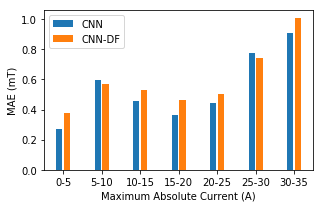

In [16]:
current_levels = list(test_by_current.keys())
plt.figure(figsize=(4.6,3))
plt.bar(np.array(current_levels)-0.5, [test_by_current[l]['MAE_mT'] for l in current_levels])
plt.bar(np.array(current_levels)+0.5, [test_by_current_divfree[l]['MAE_mT'] for l in current_levels])
xtick_labels = ['0', '0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35']
plt.gca().set_xticklabels(xtick_labels)
plt.ylabel('MAE (mT)')
plt.xlabel('Maximum Absolute Current (A)')
plt.tight_layout()
plt.legend(('CNN', 'CNN-DF'))
plt.savefig('../Figures/cnn_mae_current_levels.pdf')

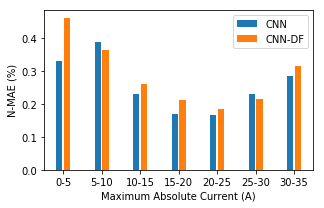

In [17]:
current_levels = list(test_by_current.keys())
plt.figure(figsize=(4.6,3))
plt.bar(np.array(current_levels)-0.5, 100*np.array([test_by_current[l]['N-MAE'] for l in current_levels]))
plt.bar(np.array(current_levels)+0.5, 100*np.array([test_by_current_divfree[l]['N-MAE'] for l in current_levels]))
xtick_labels = ['0', '0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35']
plt.gca().set_xticklabels(xtick_labels)
plt.ylabel('N-MAE (%)')
plt.xlabel('Maximum Absolute Current (A)')
plt.tight_layout()
plt.legend(('CNN', 'CNN-DF'))
plt.savefig('../Figures/cnn_n-mae_current_levels.pdf')

## Epoch Statistics


In [14]:
def plot_training_perf(root_path, root_path_df=None):
    """ 
    Extracts the data from both the CNN and CNN-DF results folders
    
        Args:
            root_path (str): path to results folder for CNN
            root_path_df (str): path to the results folder for CNN-DF
    """
    ret = extract_stats(root_path)
    if root_path_df:
        ret_df = extract_stats(root_path_df)
        assert(np.allclose(ret['epochs'], ret_df['epochs']))

    plt.figure(figsize=(4.6,5))
    width=20.
        
    plt.subplot(2,1,1)
    if root_path_df:
        plt.bar(ret['epochs'] - width/2, np.mean(ret['r2s'], axis=1), width)
        plt.bar(ret['epochs'] + width/2, np.mean(ret_df['r2s'], axis=1), width)
        plt.legend(('CNN', 'CNN-DF'))
    else:
        plt.bar(ret['epochs'], np.mean(ret['r2s'], axis=1), width)

    plt.gca().set_ylim(np.min(ret['r2s'])-0.005, 1.)

    plt.ylabel('$R^2$')
    plt.tight_layout()

    plt.subplot(2,1,2)

#     plt.bar(splits - width, maes[:,0], width, bottom=0)
#     plt.bar(splits, maes[:,1], width, bottom=0)
#     plt.bar(splits + width, maes[:,2], width, bottom=0)
    if root_path_df:
        plt.bar(ret['epochs'] - width/2, np.mean(ret['maes'], axis=1), width)
        plt.bar(ret['epochs'] + width/2, np.mean(ret_df['maes'], axis=1), width)
        plt.legend(('CNN', 'CNN-DF'))
    else:
        plt.bar(ret['epochs'], np.mean(ret['maes'], axis=1), width)

        
    plt.xlabel('Epochs')
    plt.ylabel('MAE (mT)')
    plt.tight_layout()


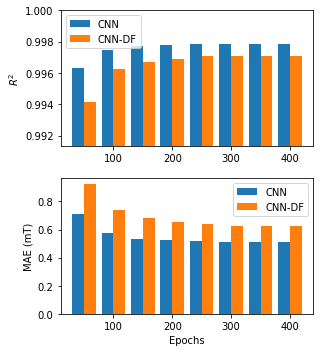

In [6]:
plot_training_perf(os.path.join(DF_PATH, 'log/cmag_dataset/epochs'), os.path.join(DF_PATH,'log/cmag_dataset/epochs_df/'))
plt.savefig('../Figures/cnn_mae_epochs.pdf')

In [7]:
ret = extract_stats(os.path.join(DF_PATH, 'log/cmag_dataset/epochs/'))
ret_df = extract_stats(os.path.join(DF_PATH, 'log/cmag_dataset/epochs_df/'))

In [8]:
output_str = 'Epochs: {:d}\nMAE: {:1.2f}\nR2: {:1.3f}\nRMSE: {:1.2f}'.format( ret_df['epochs'][6],
                                    (np.mean(ret_df['maes'], axis=1))[6],
                                     (np.mean(ret_df['r2s'], axis=1))[6],
                                     (np.mean(ret_df['rmses'], axis=1))[6])
print(output_str)

Epochs: 350
MAE: 0.62
R2: 0.997
RMSE: 0.96


In [9]:
output_str = 'Epochs: {:d}\nMAE: {:1.2f}\nR2: {:1.3f}\nRMSE: {:1.2f}'.format(ret['epochs'][6],
                                    (np.mean(ret['maes'], axis=1))[6],
                                     (np.mean(ret['r2s'], axis=1))[6],
                                     (np.mean(ret['rmses'], axis=1))[6] )
print(output_str)

Epochs: 350
MAE: 0.51
R2: 0.998
RMSE: 0.83


## Training Split Sizes

In [50]:
def extract_stats_splits(root_path):
    ss_paths = glob.glob(os.path.join(root_path, '*_ss_*'))
    r2_l = []
    rmse_l = []
    split_l = []
    mae_l = []
    r2_train_l = []
    rmse_train_l = []
    mae_train_l = []
    for path in sorted(ss_paths):
        split = int(re.findall(r'[\d]+$',path)[0])
        stats_file = tf.train.latest_checkpoint(path) + '.test_stats'
        if not os.path.exists(stats_file):
            print('could not find stats file for %s' % path)
            continue

        r2, rmse, mae = read_stats_file(stats_file)
        r2_l.append(r2)
        rmse_l.append(rmse)
        mae_l.append(mae)
        split_l.append(split)
        
        train_stats_file = tf.train.latest_checkpoint(path) + '.train_stats'
        if os.path.exists(train_stats_file):
            r2_train, rmse_train, mae_train = read_stats_file(train_stats_file)
            r2_train_l.append(r2_train)
            rmse_train_l.append(rmse_train)
            mae_train_l.append(mae_train)
        
    r2s = np.array(r2_l)
    r2s_train = np.array(r2_train_l)
    rmses = 1000 * np.array(rmse_l)
    rmses_train = 1000 * np.array(rmse_train_l)
    maes = 1000 * np.array(mae_l)
    maes_train = 1000 * np.array(mae_train_l)
    splits = np.array(split_l)
    ret = {
        'r2s': r2s,
        'maes': maes,
        'splits': splits,
        'rmses': rmses,
        'r2s_train': r2s_train,
        'rmses_train': rmses_train,
        'maes_train': maes_train
    }
    return ret
    
def plot_training_split_perf(root_path, root_path_df, is_ieee=False):
    """ 
    Extracts the data from both the CNN and CNN-DF results folders
    
        Args:
            root_path (str): path to results folder for CNN
            root_path_df (str): path to the results folder for CNN-DF
    """
    ret = extract_stats_splits(root_path)
    ret_df = extract_stats_splits(root_path_df)
    assert(np.allclose(ret['splits'], ret_df['splits']))
    
    if is_ieee:
        width=3.
        plt.figure(figsize=(3.5,2.2))
        plt.bar(ret['splits'] - width/2, np.mean(ret['maes'], axis=1), width)
        plt.bar(ret['splits'] + width/2, np.mean(ret_df['maes'], axis=1), width)
        plt.legend(('CNN', 'CNN-DF'))
        plt.xlabel('Training Set Size (%)')
        plt.ylabel('MAE (mT)')
        plt.tight_layout()
        plt.rcParams["font.size"] = "8"
    else:
        plt.figure(figsize=(4.6,5))
        width=3.

        plt.subplot(2,1,1)
        plt.bar(ret['splits'] - width/2, np.mean(ret['r2s'], axis=1), width)
        plt.bar(ret['splits'] + width/2, np.mean(ret_df['r2s'], axis=1), width)

        plt.gca().set_ylim(np.min(r2s)-0.01,1.)
        plt.legend(('CNN', 'CNN-DF'))
        plt.ylabel('$R^2$')
        plt.tight_layout()

        plt.subplot(2,1,2)

    #     plt.bar(splits - width, maes[:,0], width, bottom=0)
    #     plt.bar(splits, maes[:,1], width, bottom=0)
    #     plt.bar(splits + width, maes[:,2], width, bottom=0)
        plt.bar(ret['splits'] - width/2, np.mean(maes, axis=1), width)
        plt.bar(ret['splits'] + width/2, np.mean(maes_df, axis=1), width)
        plt.legend(('CNN', 'CNN-DF'))
        plt.xlabel('Training Set Size (%)')
        plt.ylabel('MAE (mT)')
        plt.tight_layout()
        plt.rcParams["font.size"] = "11"

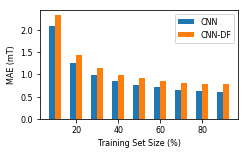

In [44]:
plot_training_split_perf(os.path.join(DF_PATH,'log/cmag_dataset/splits_fixed'), 
                         os.path.join(DF_PATH, 'log/cmag_dataset/splits_divfree/'), is_ieee=True)
plt.savefig('../Figures/cnn_splits_size_ieee.pdf')

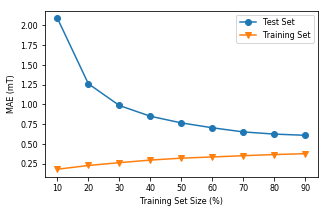

In [58]:
ret = extract_stats_splits(os.path.join(DF_PATH, 'log/cmag_dataset/splits_fixed/'))
plt.figure(figsize=(4.6, 3))
plt.plot(ret['splits'], np.mean(ret['maes'], axis=1), linestyle='-', marker='o')
plt.plot(ret['splits'], np.mean(ret['maes_train'], axis=1), linestyle='-', marker='v')
plt.xlabel('Training Set Size (%)')
plt.ylabel('MAE (mT)')
plt.legend(('Test Set', 'Training Set'))
plt.tight_layout()
plt.savefig('../Figures/cnn_learning_curve.pdf')